In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 1: Load the dataset
file_path = '/content/AmesHousing.csv'  # Update this path if needed
data = pd.read_csv(file_path)

In [4]:
# Step 2: Handle missing values
# Separate numeric and categorical columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(exclude=[np.number]).columns

# Fill missing values
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())  # For numeric columns, use mean
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])  # For categorical columns, use mode

In [23]:
# Step 3: Convert categorical columns into numerical format using one-hot encoding
data = pd.get_dummies(data)

# EDA - Understanding the dataset
print(data.describe())  # Summary statistics

            Order           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2930.00000  2.930000e+03  2930.000000   2930.000000    2930.000000   
mean   1465.50000  7.144645e+08    57.387372     69.224590   10147.921843   
std     845.96247  1.887308e+08    42.638025     21.321523    7880.017759   
min       1.00000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     733.25000  5.284770e+08    20.000000     60.000000    7440.250000   
50%    1465.50000  5.354536e+08    50.000000     69.224590    9436.500000   
75%    2197.75000  9.071811e+08    70.000000     78.000000   11555.250000   
max    2930.00000  1.007100e+09   190.000000    313.000000  215245.000000   

       Overall Qual  Overall Cond   Year Built  Year Remod/Add  Mas Vnr Area  \
count   2930.000000   2930.000000  2930.000000     2930.000000   2930.000000   
mean       6.094881      5.563140  1971.356314     1984.266553    101.896801   
std        1.411026      1.111537    30.245361       20.860286    

In [6]:
# Step 4: Feature and target separation
X = data.drop('SalePrice', axis=1)  # Features
y = data['SalePrice']  # Target (house prices)

In [7]:
# Step 5: Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Step 6: Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Step 7: Model training - Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions and evaluation for Linear Regression
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr}")
print(f"Linear Regression R²: {r2_lr}")

Linear Regression RMSE: 315028676526038.75
Linear Regression R²: -1.237823183459423e+19


In [10]:
# Step 8: Hyperparameter tuning for Random Forest using GridSearchCV
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [10, 20, 30],        # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
}

# Grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best Random Forest model
best_rf = grid_search.best_estimator_

# Predictions and evaluation for the best Random Forest model
y_pred_rf = best_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Best Random Forest RMSE: {rmse_rf}")
print(f"Best Random Forest R²: {r2_rf}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Random Forest RMSE: 26642.419179282333
Best Random Forest R²: 0.9114668841594036


In [11]:
# Step 9: Function to calculate adjusted R²
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Number of samples and features
n = X_test.shape[0]  # Number of samples in the test set
p = X_test.shape[1]  # Number of features

# Calculate adjusted R² for Random Forest
adjusted_r2_rf = adjusted_r2(r2_rf, n, p)
print(f"Best Random Forest Adjusted R²: {adjusted_r2_rf}")

Best Random Forest Adjusted R²: 0.8150290258330396


In [12]:
# Step 10: Function to predict house price based on user input
def predict_house_price(model, user_input):
    # Create a template dataframe with all features and set default values
    input_df = pd.DataFrame([np.zeros(len(X_train[0]))], columns=data.columns.drop('SalePrice'))

    # Fill in user-provided values for the relevant features (customize as needed)
    input_df['Bedroom AbvGr'] = user_input[0]  # Number of bedrooms
    input_df['Lot Area'] = user_input[1]  # Lot area
    input_df['Gr Liv Area'] = user_input[2]  # Total square footage
    input_df['Full Bath'] = user_input[3]  # Number of bathrooms
    input_df['Garage Cars'] = user_input[4]  # Number of garage spaces
    input_df['Year Built'] = 2024 - user_input[5]  # Age of house (use Year Built)

    # Ensure the user input is standardized like the training data
    input_scaled = scaler.transform(input_df)

    # Make prediction
    prediction = model.predict(input_scaled)
    return prediction[0]

In [13]:
# Step 11: Function to take user input for the main features (customize based on the dataset)
def get_user_input():
    print("Please enter the values for the following features:")

    bedrooms = float(input("Number of Bedrooms: "))
    lot_area = float(input("Lot Area (in square feet): "))
    total_sf = float(input("Total Square Footage of the house: "))
    bathrooms = float(input("Number of Bathrooms: "))
    garage_cars = float(input("Number of Garage Spaces: "))
    house_age = float(input("Age of the house in years: "))

    user_input = [bedrooms, lot_area, total_sf, bathrooms, garage_cars, house_age]
    return user_input

In [14]:
# Step 12: Predicting based on user input
user_input = get_user_input()  # Takes input from user for prediction
predicted_price = predict_house_price(best_rf, user_input)
print(f"Predicted House Price: ${predicted_price:.2f}")

Please enter the values for the following features:
Number of Bedrooms: 3
Lot Area (in square feet): 8500
Total Square Footage of the house: 2000
Number of Bathrooms: 2
Number of Garage Spaces: 1
Age of the house in years: 10
Predicted House Price: $102970.59


In [15]:
# Calculate accuracy percentage based on the existing r²_rf
accuracy_rf = r2_rf * 100
print(f"Best Random Forest Accuracy: {accuracy_rf:.2f}%")

Best Random Forest Accuracy: 91.15%


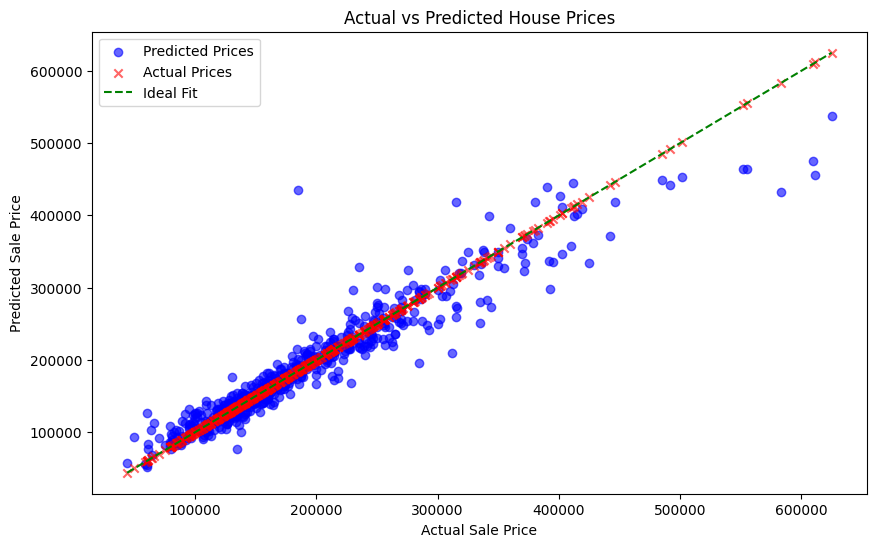

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.6, label='Predicted Prices')
plt.scatter(y_test, y_test, color='red', alpha=0.6, label='Actual Prices', marker='x')  # Actual vs Actual as a reference
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='green', linestyle='--', label='Ideal Fit')
plt.legend()
plt.show()

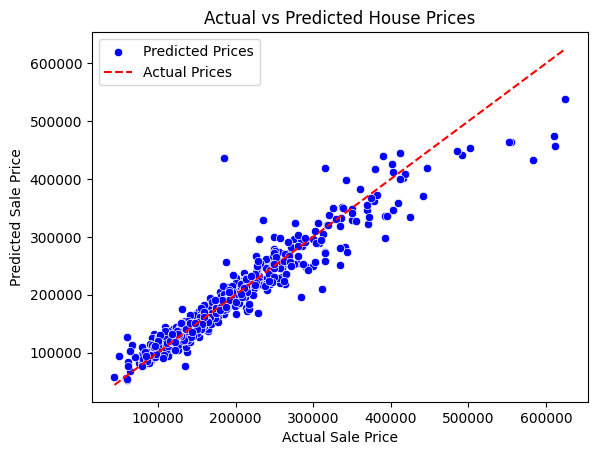

In [25]:
# Optional: Enhanced Visualization using Seaborn
sns.scatterplot(x=y_test, y=y_pred_rf, color='blue', label='Predicted Prices')
sns.lineplot(x=y_test, y=y_test, color='red', label='Actual Prices', linestyle='--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.show()